In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import dataset
from utils.prefetch_queue_shuffle import PrefetchQueue
from utils.loss_utils import *
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.data as dat
from datetime import datetime
import random
from random import shuffle
from slomo_model import SloMo_model
from utils.image_utils import imwrite
from functools import partial
import pdb
from utils.vgg16.vgg16 import vgg16
from slomo_train2 import _read_image
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_list_paths = ["data_list/frame" + str(i+1) + ".txt"
                   for i in range(9)]
dataset_objects = [dataset.Dataset(data_list_file=path)
                   for path in data_list_paths]

In [3]:
data_lists = [dataset_obj.read_data_list_file()
              for dataset_obj in dataset_objects]
dataset_frames = [tf.data.Dataset.from_tensor_slices(
                  tf.constant(data_list))
                  for data_list in data_lists]
dataset_frames = [frame.repeat().shuffle(buffer_size=int(1e6), seed=999)\
                  .map(_read_image)
                  for frame in dataset_frames]
dataset_frames = [frame.prefetch(100) for frame in dataset_frames]

# 9 sets of frames in total, 1 for each frame in a 9-frame sequence
batch_frames = [frame.batch(2)\
                .make_initializable_iterator()
                for frame in dataset_frames]

# grab the first and last frames for input
input_placeholder = tf.concat([batch_frames[0].get_next(), 
                               batch_frames[8].get_next()], 
                              axis=3)
# the middle 7 frames for ground truth
target_placeholder = tf.concat([frame.get_next() for frame
                                in batch_frames[1:8]],
                               axis=3)


In [4]:
# sess = tf.Session()
# sess.run([batch_frame.initializer for batch_frame 
#                 in batch_frames])
# inputs, targets = sess.run([input_placeholder, target_placeholder])
# pic_num = 1
# img1 = inputs[pic_num, :, :, :3]
# img2 = targets[pic_num, :, :, :3]
# img3 = targets[pic_num, :, :, 3:6]
# img7 = targets[pic_num, :, :, 6:9]
# img8 = targets[pic_num, :, :, -3:]
# img9 = inputs[pic_num, :, :, 3:]

# plt.figure(figsize=[80, 50])
# plt.subplot(611)
# plt.imshow(img1 + 1)
# plt.subplot(612)
# plt.imshow(img2 + 1)
# plt.subplot(613)
# plt.imshow(img3 + 1)
# plt.subplot(614)
# plt.imshow(img7 + 1)
# plt.subplot(615)
# plt.imshow(img8 + 1)
# plt.subplot(616)
# plt.imshow(img9 + 1)

In [5]:
sess = tf.Session()
# the first network
computer = SloMo_model(for_interpolation=False)
# the second
interpolater = SloMo_model(for_interpolation=True)
# vgg for perceptual loss
vgg_mod = vgg16(sess=sess)

# flow computations between the first and last frames
flow_01, flow_10 = computer.inference(input_placeholder)
image_0, image_1 = input_placeholder[:, :, :, :3], \
                        input_placeholder[:, :, :, 3:]

total_loss = 0
pred_imgs_t = []

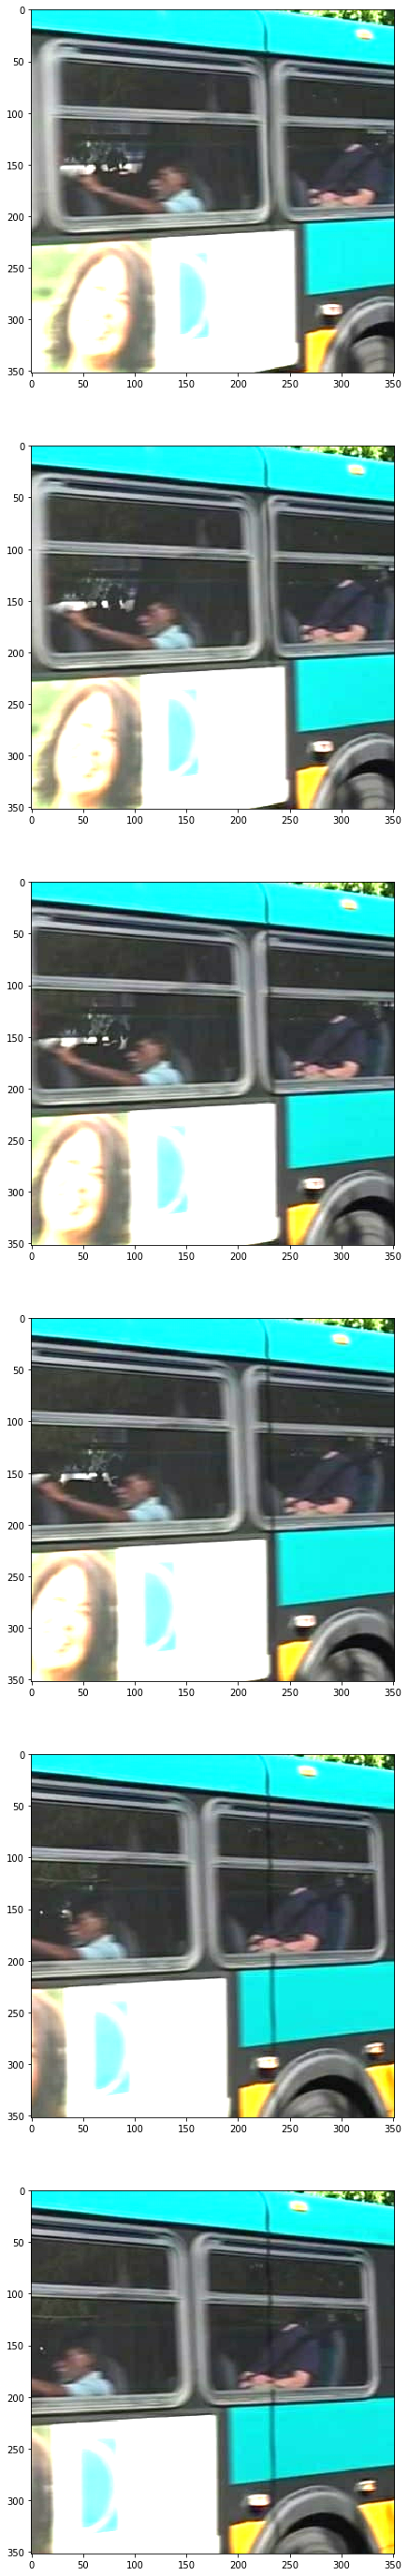

In [6]:
# img1 = img9 = None

# sess.run([batch_frame.initializer for batch_frame in batch_frames])
# # img1, img9, targets = sess.run([image_0, image_1, target_placeholder])
# # img1, img9 = sess.run([image_0, image_1])
# # img1, img9, targets = sess.run([input_placeholder[:, :, :, :3], 
# #                                 input_placeholder[:, :, :, 3:], 
# #                                 target_placeholder])
# inputs, targets = sess.run([input_placeholder, target_placeholder])

# pic_num = 1
# img1 = img1[pic_num] if type(img1) != type(None) else inputs[pic_num, :, :, :3]
# img2 = targets[pic_num, :, :, :3]
# img3 = targets[pic_num, :, :, 3:6]
# img7 = targets[pic_num, :, :, 6:9]
# img8 = targets[pic_num, :, :, -3:]
# img9 = img9[pic_num] if type(img9) != type(None) else inputs[pic_num, :, :, 3:]

# plt.figure(figsize=[80, 50])
# plt.subplot(611)
# plt.imshow(img1 + 1)
# plt.subplot(612)
# plt.imshow(img2 + 1)
# plt.subplot(613)
# plt.imshow(img3 + 1)
# plt.subplot(614)
# plt.imshow(img7 + 1)
# plt.subplot(615)
# plt.imshow(img8 + 1)
# plt.subplot(616)
# plt.imshow(img9 + 1)